# Implementacion de SOM para clasificacion de latidos

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math



In [3]:
import wfdb
import numpy as np
import os
import matplotlib.pyplot as plot
from IPython.display import display

#Comando para aumentar el tamaño de los plots
plot.rcParams['figure.figsize'] = (12.0, 10.0)

In [4]:
# Importo los datos del dataset 202 de mitdb
signals2, fields2=wfdb.srdsamp('202', channels=[0,1],  pbdir = 'mitdb') 

# Importo las anotaciones del mismo dataset
annotation = wfdb.rdann('202', 'atr', pbdir = 'mitdb')

#Me quedo con los picos de cada ECG que es donde están las anotaciones
picos=annotation.annsamp
#print(annotation.anntype.index("V"))
#Transpongo las señales leídas para poder operar mas comodamente
signals=np.matrix.transpose(signals2)

picos[-1]=0 #descarto el último pico por si el latido está interrumpido
picos[-2]=0 #descarto el anteúltimo pico por si el latido está interrumpido
picos[0]=0 #descarto el primer pico por si el latido está interrumpido
picos[1]=0 #descarto el segundo pico por si el latido está interrumpido


tam=125 #Tamaño del latido que tomo a la izquierda y a la derecha de la anotación

cantLatidos=sum(picos>tam) #Cuento la cantidad de anotaciones en el segemento a analizar

latidos=np.zeros([cantLatidos,2*tam]) #Reservo espacio para la matriz de datos cantLatidos x 2*tam

latidosNorm=np.zeros([2*tam,cantLatidos])#Reservo espacio para la matriz de datos normalizados

idxLat=0 #Inicializo en cero para procesar cada uno de los picos

for i in picos:
    if i>tam: # i>tam por si el primer latido está trunco
        latidos[idxLat]=signals[0][i-tam:i+tam] #tomo tam muestras a la izquerda y a la derecha de la anotación
        idxLat+=1 #incremento el número de latidos

#El set de latidos está en latidos y el largo de cada latido es de tam muestras

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente

# A continuación calculo la media y la varianza de cada elemento del vector de datos para poder normalizar cada dato


In [5]:
#Cuento cuantos latidos hay
cantLatidos = latidos.shape[1]
print(cantLatidos)

# A continuación calculo la media de cada latido
medias=np.zeros(cantLatidos)
for i in range(0,cantLatidos):
    medias[i]=np.mean(latidos[:,i])
    
#Le resto su media a cada latido ya que solo me interesa la "forma"
for idx in range(0,cantLatidos):
    latidos[:,idx]=latidos[:,idx]-np.ones(2*tam)*medias[idx]

2142


In [6]:
#Que tipo de latidos hay?
kinds = set(annotation.anntype)
print(kinds)


#Imprimo cuantos latidos hay de cada tipo
for i in kinds:
    print(i, end='')
    print(': ',end='')
    print(annotation.anntype.count(i))
    #print(annotation.anntype.index(i))

{'N', '+', 'V', 'A', 'a', 'F', '|'}
N: 2061
+: 8
V: 19
A: 36
a: 19
F: 1
|: 2


In [7]:
#Genero un arreglo con la clase de cada latido identificada por un numero.
#Distingo normales, auriculares prematuros y ventriculares prematuros. El resto los englobo en otros.

clases = list(annotation.anntype)

for i in range(0,len(clases)):
    if clases[i]=='N':
        clases[i]=0
    elif clases[i]=='A':
        clases[i]=1
    elif clases[i]=='V':
        clases[i]=2
    else:
        clases[i]=3
    

In [8]:
#Genero una lista de indices para cada tipo de latido a entrenar
    
indexesA = [i-2 for i,x in enumerate(clases) if x == 1]
indexesN = [i-2 for i,x in enumerate(clases) if x == 0]
indexesV = [i-2 for i,x in enumerate(clases) if x == 2]

#Descarto los primeros y ultimos por no ser "tipicos" para entrenar (apreciacion subjetiva)
indexesN = indexesN[2:-2]
indexesA = indexesA[4:-2]


latidosA = latidos[:,indexesA]
latidosN = latidos[:,indexesN]
latidosV = latidos[:,indexesV]

#Los normales de entrenamiento los tomo de todo el rango para que sean representativos
trainindexesN = [312,759,1096,1540,1984]

#Tomo cinco latidos de cada tipo para entrenar
trainA = latidosA[:,range(0,5)]
trainN = latidos[:,trainindexesN]
trainV = latidosV[:,range(0,5)]


clasesA = [clases[i+2] for i in indexesA]
clasesN = [clases[i+2] for i in indexesN]
clasesV = [clases[i+2] for i in indexesV]

clasestrainA =  [clasesA[i] for i in range(0,5)]
clasestrainN =  [clases[i+2] for i in trainindexesN]
clasestrainV =  [clasesV[i] for i in range(0,5)]

#Concateno los latidos para entrenar
latidostrain = np.concatenate((trainA,trainN,trainV),axis=1)
latidosclass = np.concatenate((clasestrainA,clasestrainN,clasestrainV))

#Transpongo para uso futuro mas comodo
latidostrain = np.transpose(latidostrain)

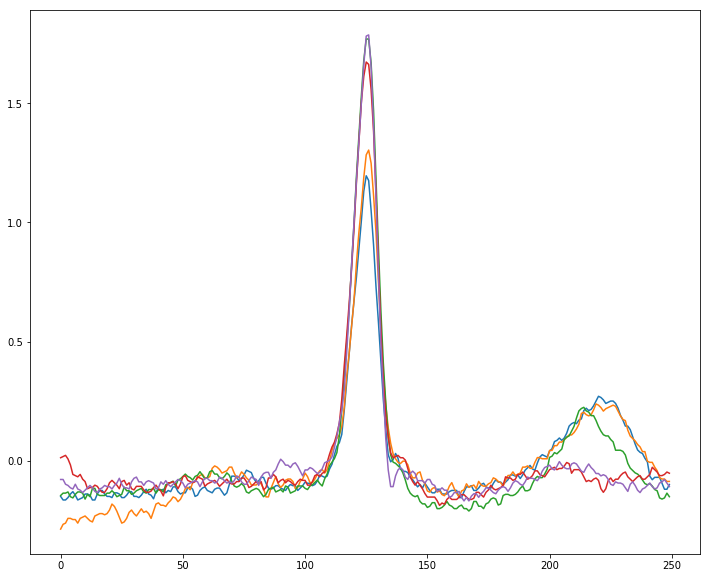

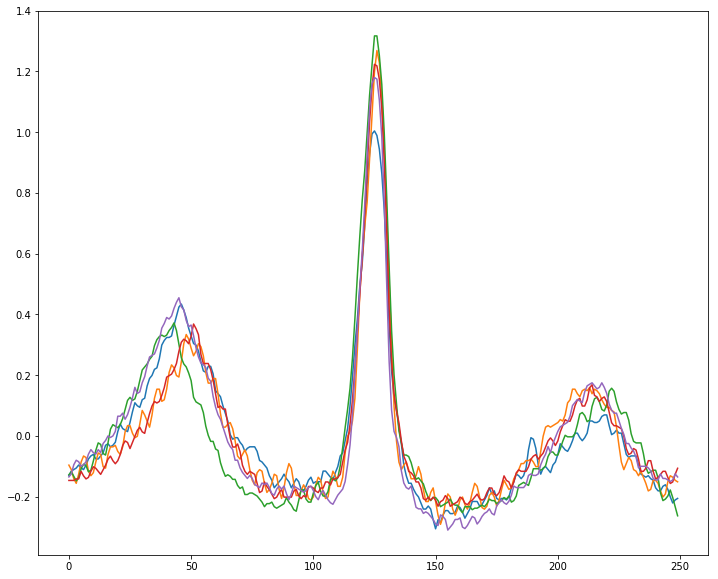

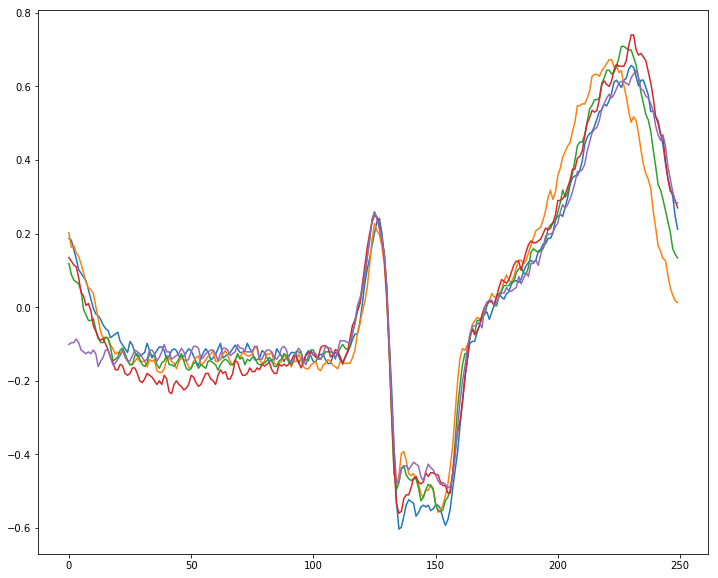

In [9]:
#Plot de los latidos de cada clase
plt.plot(trainN)
plt.show()
plt.plot(trainA)
plt.show()
plt.plot(trainV)
plt.show()


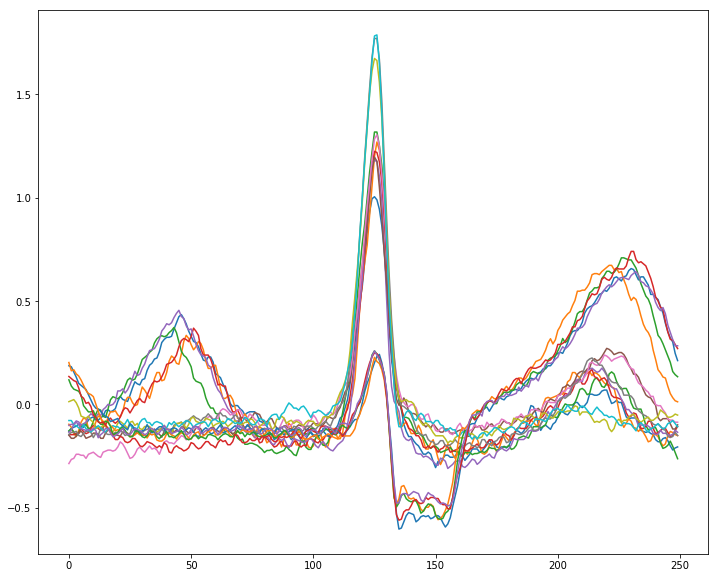

In [10]:
#Plot de todos los latidos

latidostrain = np.transpose(latidostrain)
plt.plot(latidostrain)
plt.show()

latidostrain = np.transpose(latidostrain)



In [11]:
#Genero y entreno una red SOM con los quince latidos de entrenamiento

from minisom import MiniSom
from matplotlib import gridspec

### Initialization and training ###

X=8
Y=8

som2 = MiniSom(X,Y,250,sigma=5,learning_rate=0.5)

som2.random_weights_init(latidostrain)

print('Start training...')

som2.train_random(latidostrain,50000)

print('Done training!')

Start training...
Done training!


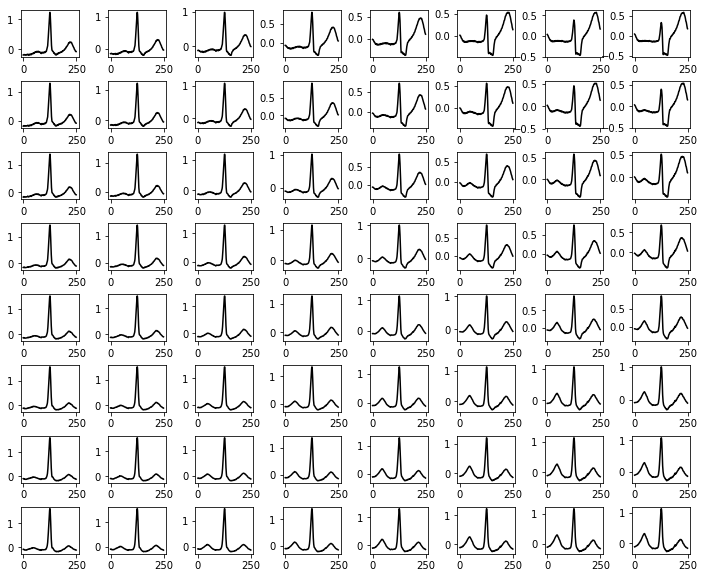

In [12]:
#Visualizo los pesos de cada nodo de la red SOM de forma gráfica

fig = plt.figure()

gs = gridspec.GridSpec(X,Y)

for i in range(0,X):
    for j in range(0,Y):
        ax1 = fig.add_subplot(gs[i,j])
        ax1.plot(som2.weights[j,X-1-i,:],'-',c='k')

        
gs.update(wspace=0.5, hspace=0.5)
fig = plt.gcf()

plt.show()

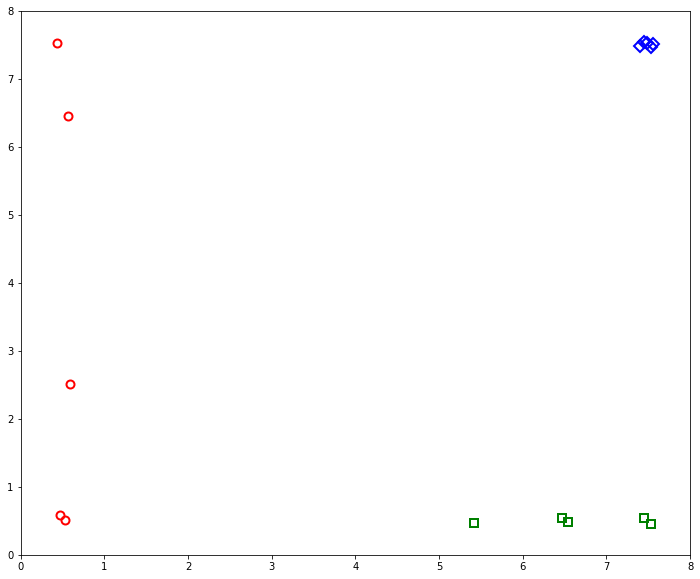

In [13]:
#Grafico donde caen los latidos de entrenamiento en el mapa

from pylab import plot,axis,show,pcolor,colorbar,bone

markers = ['o','s','D']
colors = ['r','g','b']

#rojo = normal
#verde = auricular
#azul = ventricular

for cnt,xx in enumerate(latidostrain):
 w = som2.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5+np.random.randn(1)/20,w[1]+.5+np.random.randn(1)/20,markers[latidosclass[cnt]],markerfacecolor='None',
   markeredgecolor=colors[latidosclass[cnt]],markersize=8,markeredgewidth=2)
axis([0,som2.weights.shape[0],0,som2.weights.shape[1]])
show()

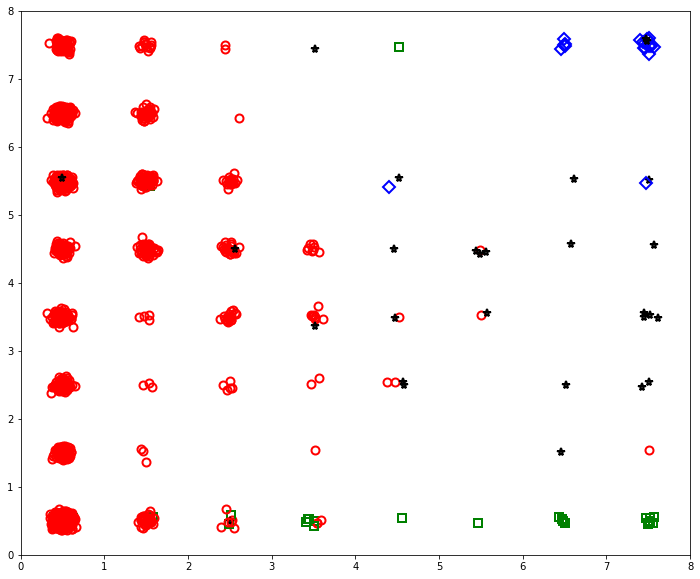

In [14]:
#Grafico donde caen todos los latidos en el mapa

from pylab import plot,axis,show,pcolor,colorbar,bone


#rojo = normal
#verde = auricular
#azul = ventricular
#negro = otros

markers = ['o','s','D','*']
colors = ['r','g','b','k']

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente
for cnt,xx in enumerate(latidos):
 w = som2.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5+np.random.randn(1)/20,w[1]+.5+np.random.randn(1)/20,markers[clases[cnt+2]],markerfacecolor='None',
   markeredgecolor=colors[clases[cnt+2]],markersize=8,markeredgewidth=2)
axis([0,som2.weights.shape[0],0,som2.weights.shape[1]])
show()

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente

In [16]:

#Imprimo cuantos latidos se encontraron de cada clase y el porcentaje de aciertos.

N_a = 0
N_v = 0
N_n = 0
N_n_right = 0
N_n_wrong = 0
N_a_right = 0
N_a_wrong = 0
N_v_right = 0
N_v_wrong = 0
N_none = 0
N_none_right = 0
N_none_wrong = 0

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente
for cnt,xx in enumerate(latidos):
    w = som2.winner(xx) # getting the winner
    if(w[1]>3):
        N_n+=1
        if clases[cnt+2]==0:
            N_n_right +=1
        else:
            N_n_wrong +=1
    elif (w[0]<2):
        N_a+=1
        if clases[cnt+2]==1:
            N_a_right +=1
        else:
            N_a_wrong +=1
    elif (w[0]>6):
        N_v+=1
        if clases[cnt+2]==2:
            N_v_right +=1
        else:
            N_v_wrong +=1
    else:
        N_none+=1
        if clases[cnt+2]==3:
            N_none_right +=1
        else:
            N_none_wrong +=1
        
print('Normales hallados: ',end='')
print(N_n)
print('Correctamente: ',end='')
print(N_n_right)
print('Incorrectamente: ',end='')
print(N_n_wrong)
print('Porcentaje correcto: ',end='')
print('{0:,.2f}'.format(N_n_right*100/N_n),end='%\n')
print('------------------------------')
print('Auriculares hallados: ',end='')
print(N_a)
print('Correctamente: ',end='')
print(N_a_right)
print('Incorrectamente: ',end='')
print(N_a_wrong)
print('Porcentaje correcto: ',end='')
print('{0:,.2f}'.format(N_a_right*100/N_a),end='%\n')
print('------------------------------')
print('Ventriculares hallados: ',end='')
print(N_v)
print('Correctamente: ',end='')
print(N_v_right)
print('Incorrectamente: ',end='')
print(N_v_wrong)
print('Porcentaje correcto: ',end='')
print('{0:,.2f}'.format(N_v_right*100/N_v),end='%\n')
print('------------------------------')
print('Otros hallados: ',end='')
print(N_none)
print('Correctamente: ',end='')
print(N_none_right)
print('Incorrectamente: ',end='')
print(N_none_wrong)
print('Porcentaje correcto: ',end='')
print('{0:,.2f}'.format(N_none_right*100/N_none),end='%\n')

latidos=np.matrix.transpose(latidos) #vuelvo a acondicionar los latidos para seguir operando cómodamente

Normales hallados: 61
Correctamente: 7
Incorrectamente: 54
Porcentaje correcto: 11.48%
------------------------------
Auriculares hallados: 185
Correctamente: 0
Incorrectamente: 185
Porcentaje correcto: 0.00%
------------------------------
Ventriculares hallados: 874
Correctamente: 0
Incorrectamente: 874
Porcentaje correcto: 0.00%
------------------------------
Otros hallados: 1022
Correctamente: 3
Incorrectamente: 1019
Porcentaje correcto: 0.29%
